#### Inicialização de variáveis e importação de bibliotecas

In [46]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras import layers, Input
from keras.preprocessing.image import load_img, img_to_array


AUTOTUNE = tf.data.AUTOTUNE

batch_size = 32
img_height = 210
img_width = 210
data_dir='data/cuted/'
prediction_data='data/predict/page_1_p7.png'

#### Definição dos diretórios de treinamento e validação
    



O primeiro conjunto de dados, ```train_ds```, é para treinamento. Lendo imagens do diretório especificado em data_dir, dividindo 20% dos dados para validação (deixando 80% para treinamento) com a opção ```validation_split=0.2```, e especificando que este é o conjunto de "treinamento" com ```subset="training"```. Você também está definindo uma semente para a divisão dos dados com ```seed=123```, redimensionando todas as imagens para o tamanho especificado em ```(img_height, img_width)```, e definindo o tamanho do lote com ```batch_size```.

O segundo conjunto de dados, val_ds, é para validação. As opções são as mesmas, exceto que subset é definido como "validation", indicando que este conjunto de dados deve ser a parte de validação da divisão.

In [47]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4558 files belonging to 3 classes.
Using 3647 files for training.
Found 4558 files belonging to 3 classes.
Using 911 files for validation.


In [48]:
class_names = train_ds.class_names
print(class_names)

['header', 'non-header', 'predict']


#### Plotagem de imagens de treinamento e suas classes



Criação de gráfico de 3x3 que mostra 9 imagens de treinamento e suas classes correspondentes. Usando o conjunto de dados de treinamento, train_ds, e iterando sobre ele para obter um lote de imagens e rótulos. Permitindo a plotagem das imagens e rótulos correspondentes.

2024-04-03 09:53:01.761911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


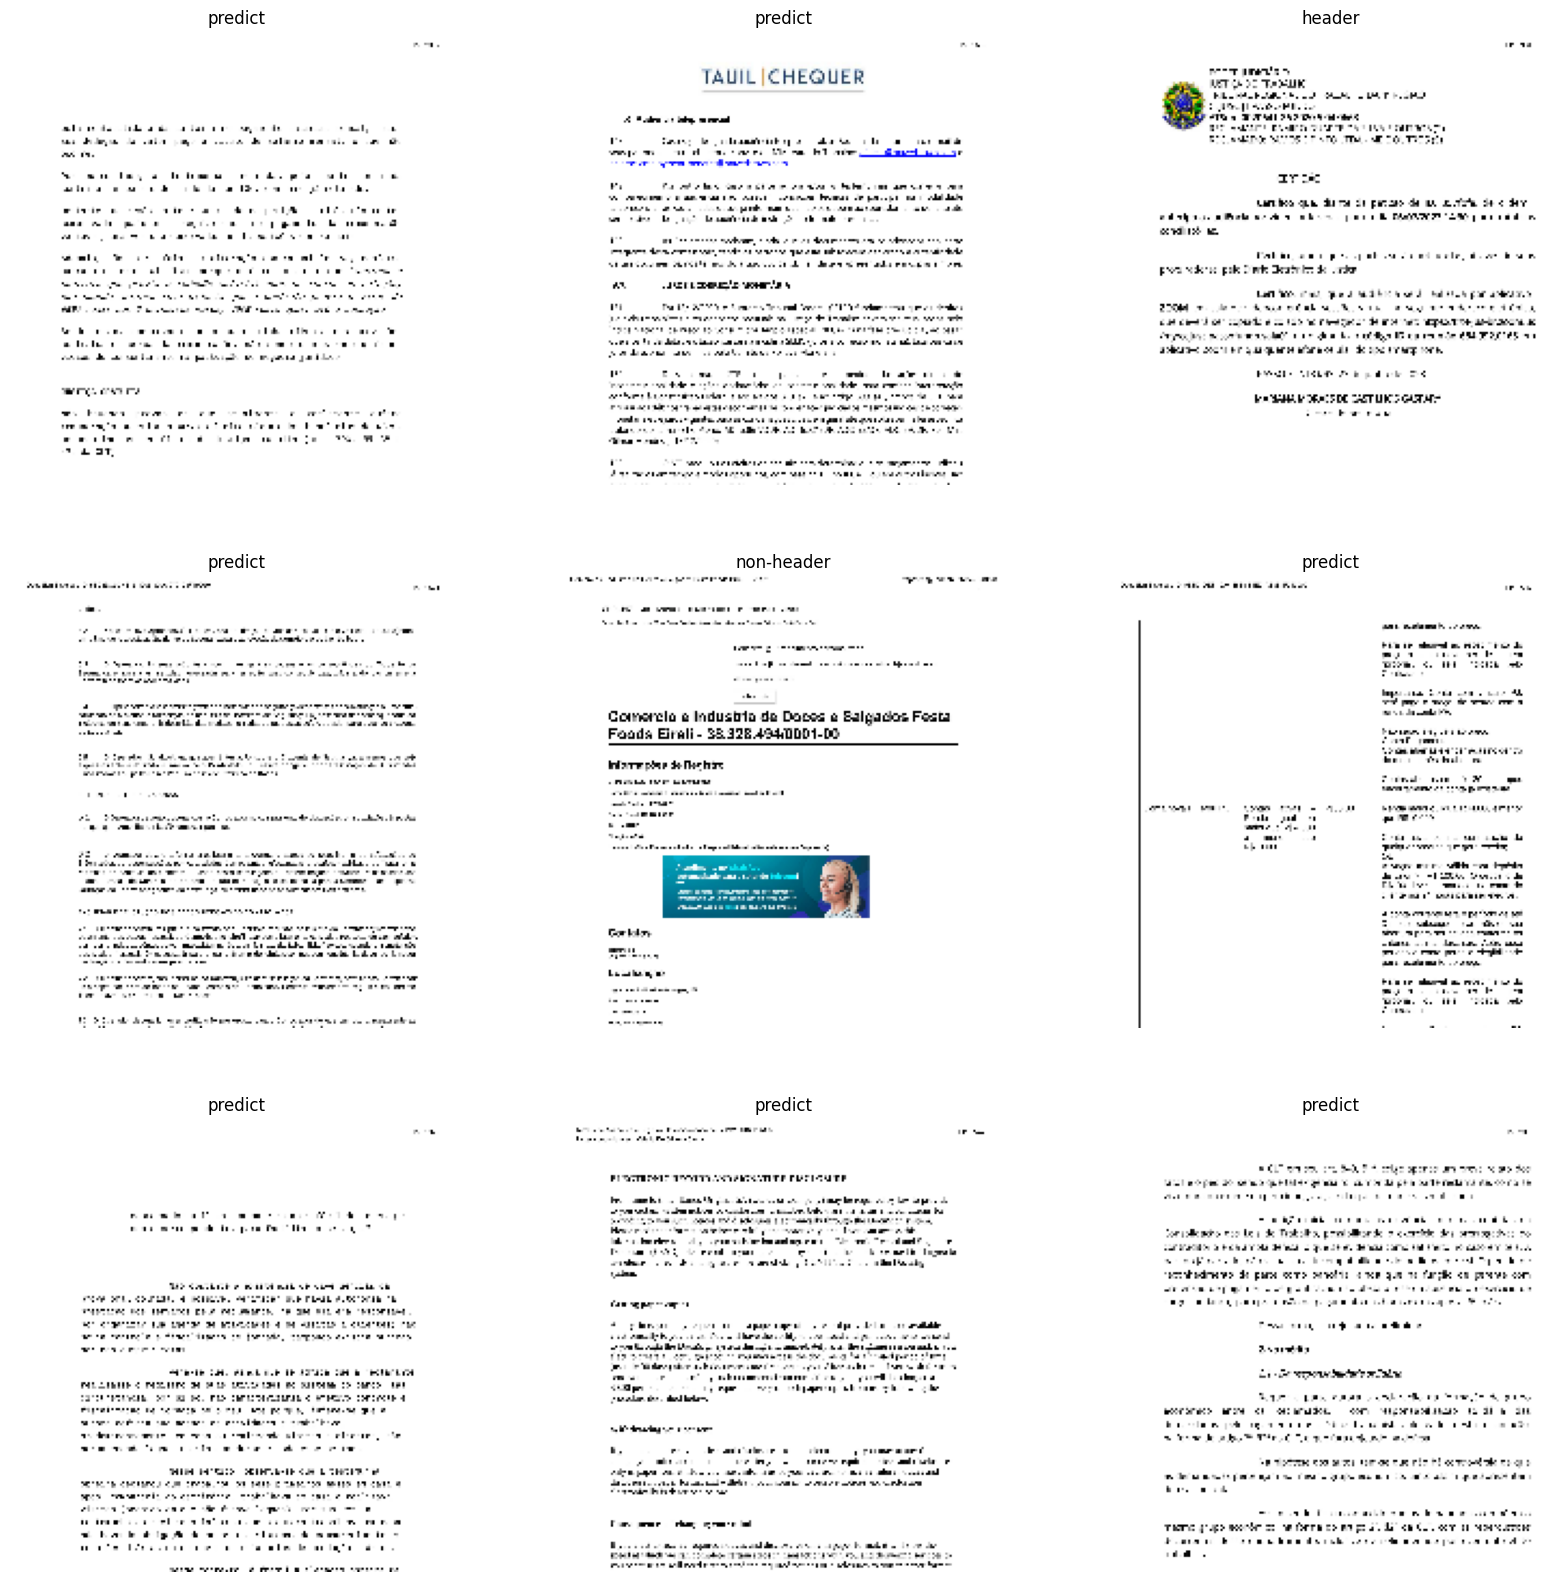

In [49]:
import matplotlib.pyplot as plt
i=0
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Otimização de desempenho dos conjuntos de dados


```.cache()```: mantém os dados na memória depois de serem carregados do disco. Isso garante que o conjunto de dados não precisa ser recarregado a cada época, melhorando o desempenho.  

```.shuffle(1000)```: randomiza a ordem dos exemplos no conjunto de dados de treinamento. Isso é importante para evitar que o modelo aprenda dependências indesejadas da ordem dos exemplos.  

```.prefetch(buffer_size=AUTOTUNE)``` antecipa o carregamento dos dados para a próxima época enquanto o modelo está treinando na época atual. Isso melhora o desempenho ao reduzir o tempo de inatividade entre as épocas. AUTOTUNE permite que o TensorFlow escolha automaticamente o número de lotes para antecipar.  


Para o conjunto de dados de validação, apenas ```.cache()``` e ```.prefetch(buffer_size=AUTOTUNE)``` são usados, pois não é necessário embaralhar os exemplos.

In [50]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Padronização dos dados



Normalização dos valores de pixel das imagens para que estejam no intervalo de [0, 1]. Isso é feito dividindo cada valor de pixel por 255, pois um canal RGB tem valores de pixel no intervalo [0, 255].

In [51]:
normalization_layer = keras.layers.Rescaling(1./255)

#### Definição do Modelo



```num_classes = len(class_names)```: Define o número de classes que o modelo precisa prever. Isso é baseado no número de nomes de classes fornecidos.

```model = Sequential()```: Inicia a definição de um novo modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.

```Input(shape=(img_height, img_width, 3))```: Define a forma da entrada para o modelo. Neste caso, a entrada é uma imagem colorida (3 canais para vermelho, verde e azul) com altura e largura especificadas.

```layers.Rescaling(1./255)```: Reescala os valores de pixel da imagem para o intervalo [0,1].

```layers.Conv2D(16, 3, padding='same', activation='relu')```: Adiciona uma camada convolucional 2D com 16 filtros, um tamanho de kernel de 3 e ativação ReLU.

```layers.MaxPooling2D()```: Adiciona uma camada de pooling para reduzir a dimensionalidade espacial.

As próximas duas camadas Conv2D e MaxPooling2D são semelhantes à 5ª e 6ª linha, mas com mais filtros na camada convolucional.

```layers.Flatten()```: Achata a saída da última camada de pooling para um vetor unidimensional.

```layers.Dense(128, activation='relu')```: Adiciona uma camada densamente conectada com 128 neurônios e ativação ReLU.

```layers.Dense(num_classes)```: Adiciona uma camada densa final com um número de neurônios igual ao número de classes. Esta camada produz a saída do modelo.

In [52]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 210, 210, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 210, 210, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 105, 105, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 105, 105, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,561,891 (21.22 MB)

 Trainable params: 5,561,891 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2024-04-03 09:53:16.463718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:258: Filling up shuffle buffer (this may take a while): 28 of 1000
2024-04-03 09:53:26.493849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:258: Filling up shuffle buffer (this may take a while): 67 of 1000
2024-04-03 09:53:36.526492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:258: Filling up shuffle buffer (this may take a while): 102 of 1000
2024-04-03 09:53:38.099847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


114/114 ━━━━━━━━━━━━━━━━━━━━ 61s 239ms/step - accuracy: 0.6595 - loss: 1.0045 - val_accuracy: 0.8244 - val_loss: 0.4973
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.8595 - loss: 0.4004 - val_accuracy: 0.8452 - val_loss: 0.3907
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.9034 - loss: 0.2519 - val_accuracy: 0.9056 - val_loss: 0.2677
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.9428 - loss: 0.1361 - val_accuracy: 0.9199 - val_loss: 0.2238
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - accuracy: 0.9797 - loss: 0.0730 - val_accuracy: 0.9232 - val_loss: 0.2208
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.9883 - loss: 0.0404 - val_accuracy: 0.9319 - val_loss: 0.2332
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.9891 - loss: 0.0413 - val_accuracy: 0.9232 - val_loss: 0.2161
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step - accuracy: 0.9963 - loss: 0.0194 - val

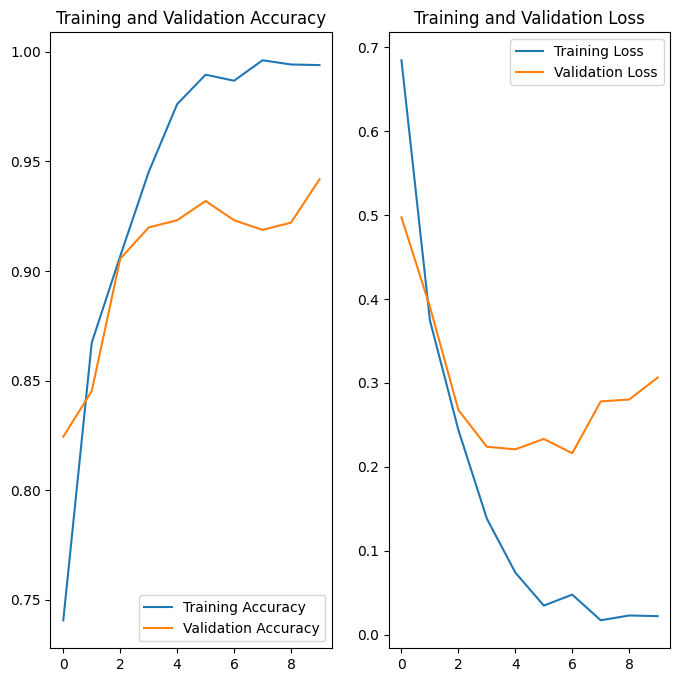

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:

# Load the image
img = load_img(prediction_data, target_size=(img_height, img_width))

# Convert the image to an array and normalize it
img_array = img_to_array(img)
img_array = img_array / 255.0

# Expand the dimensions of the image
img_array = np.expand_dims(img_array, axis=0)

# Ensure the model is loaded and compiled
# model = tf.keras.models.load_model('path_to_your_model.h5')

# Make a prediction
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
This image most likely belongs to predict with a 100.00 percent confidence.


In [57]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [58]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [60]:
# epochs = 15
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [61]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()